# Final Model Evaluation & Analysis: XGBoost

After identifying that the XGBoost performed better than the Random Forest, we went about doing an extensive grid search to find the best parameters, we tried dropping some features to see if our metrics improved, then did walk_forward vallidation to find the best time split and to see that our metrics were consistent with different time splits.

## Grid Search

In [2]:
from itertools import product
from sklearn.metrics import precision_score
import pandas as pd
import matplotlib as plt
from xgboost import XGBClassifier

def grid_search_xgb(df, features, param_grid, start=1000, step=1000, threshold=0.6, alpha=0.7):
    """
    Grid search with a combined scoring metric:
    balanced_score = test_precision - alpha * (overfit_ratio - 1)
    """
    best_score = -1
    best_params = None
    results = []

    keys, values = zip(*param_grid.items())

    for combo in product(*values):
        params = dict(zip(keys, combo))
        print(f"\n🔍 Testing params: {params}")

        # default values for params not in grid search
        model = XGBClassifier(
            n_estimators=params.get('n_estimators', 200),
            max_depth=params.get('max_depth', 3),
            learning_rate=params.get('learning_rate', 0.05),
            subsample=params.get('subsample', 0.8),
            colsample_bytree=params.get('colsample_bytree', 0.8),
            gamma=params.get('gamma', 0.2),
            reg_alpha=params.get('reg_alpha', 1),
            reg_lambda=params.get('reg_lambda', 5),
            tree_method='hist',
            random_state=1
        )

        # Run backtest and collect precision metrics
        all_preds = []
        train_precisions, test_precisions = [], []

        for i, idx in enumerate(range(start, df.shape[0], step), 1):
            train = df.iloc[:idx].copy()
            test = df.iloc[idx:idx + step].copy()

            model.fit(train[features], train['target'])
            train_preds = (model.predict_proba(train[features])[:, 1] >= threshold).astype(int)
            test_preds = (model.predict_proba(test[features])[:, 1] >= threshold).astype(int)

            train_prec = precision_score(train['target'], train_preds)
            test_prec = precision_score(test['target'], test_preds)

            train_precisions.append(train_prec)
            test_precisions.append(test_prec)

            preds = pd.DataFrame({'target': test['target'], 'Predictions': test_preds}, index=test.index)
            all_preds.append(preds)

        avg_train = sum(train_precisions) / len(train_precisions)
        avg_test = sum(test_precisions) / len(test_precisions)
        overfit_ratio = avg_train / avg_test
        precision = precision_score(pd.concat(all_preds)['target'], pd.concat(all_preds)['Predictions'])

        # Compute balanced score
        balanced_score = avg_test - alpha * (overfit_ratio - 1)

        print(f"Average Train Precision: {avg_train:.3f}")
        print(f"Average Test Precision:  {avg_test:.3f}")
        print(f"Overfitting Ratio:       {overfit_ratio:.2f}")
        print(f"Balanced Score:          {balanced_score:.4f}")

        results.append({
            'params': params,
            'train_prec': avg_train,
            'test_prec': avg_test,
            'overfit': overfit_ratio,
            'precision': precision,
            'balanced_score': balanced_score
        })

        if balanced_score > best_score:
            best_score = balanced_score
            best_params = params

    print("\n✅ Best Params (balanced scoring):")
    print(best_params)
    print(f"Best Balanced Score: {best_score:.4f}")
    return best_params, results

# did previous smaller grid search to find base best parameters and went from there
best_depth = 3
best_lr = 0.05

param_grid = {
    'max_depth': [best_depth-1, best_depth, best_depth+1],  # [2,3,4]
    'learning_rate': [best_lr/2, best_lr, best_lr*1.5],    # [0.025, 0.05, 0.075]
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 1, 2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],

}
df = pd.read_csv("../data/2019-2023_stock_with_features_dif_tickers.csv")
features = ['quantity', 'volume', 'ibovespa_close', 'day_of_week', 'price_range', 'volume_per_quantity', 'rolling_std_5', 'rolling_return_5', 'momentum_5', 'rolling_volume_5', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_55', 'Trend_55', 'Close_Ratio_220']

best_params, results = grid_search_xgb(df, features, param_grid)



🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.759
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5765

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.665
Overfitting Ratio:       1.14
Balanced Score:          0.5700

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.651
Overfitting Ratio:       1.17
Balanced Score:          0.5290

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.761
Average Test Precision:  0.681
Overfitting Ratio:       1.12
Balanced Score:          0.5977

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.757
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6038

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6068

🔍 Testing params: {'max_depth': 2, 'learn

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5087

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.644
Overfitting Ratio:       1.18
Balanced Score:          0.5179

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6006

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.640
Overfitting Ratio:       1.17
Balanced Score:          0.5185

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5249

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5163

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.760
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5762

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.665
Overfitting Ratio:       1.14
Balanced Score:          0.5700

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.653
Overfitting Ratio:       1.17
Balanced Score:          0.5354

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.762
Average Test Precision:  0.681
Overfitting Ratio:       1.12
Balanced Score:          0.5976

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.757
Average Test Precision:  0.680
Overfitting Ratio:       1.11
Balanced Score:          0.6005

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6069

🔍 Testing params: {'max_depth': 2, 

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5087

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.644
Overfitting Ratio:       1.18
Balanced Score:          0.5178

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6008

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.640
Overfitting Ratio:       1.17
Balanced Score:          0.5184

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5250

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5165

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.760
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5760

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.664
Overfitting Ratio:       1.14
Balanced Score:          0.5689

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.654
Overfitting Ratio:       1.17
Balanced Score:          0.5355

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.762
Average Test Precision:  0.678
Overfitting Ratio:       1.12
Balanced Score:          0.5906

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.758
Average Test Precision:  0.678
Overfitting Ratio:       1.12
Balanced Score:          0.5954

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6069

🔍 Testing params: {'max_depth': 2, 'learn

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5072

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.643
Overfitting Ratio:       1.18
Balanced Score:          0.5151

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6004

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.639
Overfitting Ratio:       1.17
Balanced Score:          0.5181

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5252

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 1, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5164

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.759
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5765

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.665
Overfitting Ratio:       1.14
Balanced Score:          0.5700

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.651
Overfitting Ratio:       1.17
Balanced Score:          0.5290

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.761
Average Test Precision:  0.681
Overfitting Ratio:       1.12
Balanced Score:          0.5977

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.757
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6038

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6068

🔍 Testing params: {'max_depth': 2, 'learn

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5087

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.644
Overfitting Ratio:       1.18
Balanced Score:          0.5179

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6006

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.640
Overfitting Ratio:       1.17
Balanced Score:          0.5185

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5249

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5163

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.760
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5762

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.665
Overfitting Ratio:       1.14
Balanced Score:          0.5700

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.653
Overfitting Ratio:       1.17
Balanced Score:          0.5354

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.762
Average Test Precision:  0.681
Overfitting Ratio:       1.12
Balanced Score:          0.5976

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.757
Average Test Precision:  0.680
Overfitting Ratio:       1.11
Balanced Score:          0.6005

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6069

🔍 Testing params: {'max_depth': 2, 

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5087

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.644
Overfitting Ratio:       1.18
Balanced Score:          0.5178

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6008

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.640
Overfitting Ratio:       1.17
Balanced Score:          0.5184

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5250

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5165

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.760
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5760

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.664
Overfitting Ratio:       1.14
Balanced Score:          0.5689

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.654
Overfitting Ratio:       1.17
Balanced Score:          0.5355

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.762
Average Test Precision:  0.678
Overfitting Ratio:       1.12
Balanced Score:          0.5906

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.758
Average Test Precision:  0.678
Overfitting Ratio:       1.12
Balanced Score:          0.5954

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6069

🔍 Testing params: {'max_depth': 2, 'learn

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5072

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.643
Overfitting Ratio:       1.18
Balanced Score:          0.5151

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6004

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.639
Overfitting Ratio:       1.17
Balanced Score:          0.5181

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5252

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 3, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5164

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.759
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5765

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.665
Overfitting Ratio:       1.14
Balanced Score:          0.5700

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.651
Overfitting Ratio:       1.17
Balanced Score:          0.5290

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.761
Average Test Precision:  0.681
Overfitting Ratio:       1.12
Balanced Score:          0.5977

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.757
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6038

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6068

🔍 Testing params: {'max_depth': 2, 'learn

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5087

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.644
Overfitting Ratio:       1.18
Balanced Score:          0.5179

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6006

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.640
Overfitting Ratio:       1.17
Balanced Score:          0.5185

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5249

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5163

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.760
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5762

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.665
Overfitting Ratio:       1.14
Balanced Score:          0.5700

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.653
Overfitting Ratio:       1.17
Balanced Score:          0.5354

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.762
Average Test Precision:  0.681
Overfitting Ratio:       1.12
Balanced Score:          0.5976

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.757
Average Test Precision:  0.680
Overfitting Ratio:       1.11
Balanced Score:          0.6005

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6069

🔍 Testing params: {'max_depth': 2, 

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5087

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.644
Overfitting Ratio:       1.18
Balanced Score:          0.5178

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6008

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.640
Overfitting Ratio:       1.17
Balanced Score:          0.5184

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5250

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 0.5, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5165

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.760
Average Test Precision:  0.670
Overfitting Ratio:       1.13
Balanced Score:          0.5760

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.754
Average Test Precision:  0.664
Overfitting Ratio:       1.14
Balanced Score:          0.5689

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.764
Average Test Precision:  0.654
Overfitting Ratio:       1.17
Balanced Score:          0.5355

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}
Average Train Precision: 0.762
Average Test Precision:  0.678
Overfitting Ratio:       1.12
Balanced Score:          0.5906

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.758
Average Test Precision:  0.678
Overfitting Ratio:       1.12
Balanced Score:          0.5954

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.752
Average Test Precision:  0.681
Overfitting Ratio:       1.11
Balanced Score:          0.6069

🔍 Testing params: {'max_depth': 2, 'learn

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.763
Average Test Precision:  0.641
Overfitting Ratio:       1.19
Balanced Score:          0.5072

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.759
Average Test Precision:  0.643
Overfitting Ratio:       1.18
Balanced Score:          0.5151

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.754
Average Test Precision:  0.679
Overfitting Ratio:       1.11
Balanced Score:          0.6004

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.750
Average Test Precision:  0.639
Overfitting Ratio:       1.17
Balanced Score:          0.5181

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.6}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.762
Average Test Precision:  0.648
Overfitting Ratio:       1.18
Balanced Score:          0.5252

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.025, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.8, 'colsample_bytree': 0.8}


/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Average Train Precision: 0.757
Average Test Precision:  0.642
Overfitting Ratio:       1.18
Balanced Score:          0.5164

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.05, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.6}
Average Train Precision: 0.761
Average Test Precision:  0.655
Overfitting Ratio:       1.16
Balanced Score:          0.5415

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.05, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.6, 'colsample_bytree': 0.8}
Average Train Precision: 0.759
Average Test Precision:  0.653
Overfitting Ratio:       1.16
Balanced Score:          0.5397

🔍 Testing params: {'max_depth': 2, 'learning_rate': 0.05, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'subsample': 0.8, 'colsample_bytree': 0.6}
Average Train Precision: 0.764
Average Test Precision:  0.656
Overfitting Ratio:       1.16
Balanced Score:          0.5413

🔍 Testing params: {'max_depth': 2, 'learning

This code runs for >30 minutes to find the best params, Here are the best params found:

```python
model = XGBClassifier(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.05,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    gamma=1,
    reg_alpha=2,
    reg_lambda=5,
    tree_method='hist',
    random_state=1
)
```

Here are the metrics for these params:

```python
✅ Best Params (balanced scoring):
{'max_depth': 2, 'learning_rate': 0.05, 'min_child_weight': 5, 'gamma': 1, 'reg_alpha': 2, 'subsample': 0.6, 'colsample_bytree': 0.6}
Best Balanced Score: 0.5504
Average Train Precision: 0.760
Average Test Precision:  0.656
Overfitting Ratio: 1.16
```

# Testing Features Individually

We decided to remove some low importance features one by one and in groups to see if we could improve our metrics with the following code:

In [ ]:
features = ['quantity', 'volume', 'ibovespa_close', 'day_of_week', 'price_range', 'volume_per_quantity', 'rolling_std_5', 'rolling_return_5', 'momentum_5', 'rolling_volume_5', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_55', 'Trend_55', 'Close_Ratio_220']

# drop low importance features to show how it performs, better precision? lower overfitting?
feature_to_drop = ['quantity'] # tested some low importance features
features = [f for f in features if f not in feature_to_drop]

df = df.drop(columns=feature_to_drop)

We did not find an increased balanced score by removing any combination of features.

For the sake of brevity we won't show every combination of features we chose to drop. Below is the output when we dropped both quantity & volume, as you see our balanced score went down.

```python
=== Evaluation ===
Precision: 0.6463
Recall: 0.2634
Accuracy: 0.5680

=== Feature Importance ==
Average Train Precision: 0.754
Average Test Precision:  0.655
Overfitting Ratio: 1.15
Balanced Score: 0.4947

Close_Ratio_5             89.75
momentum_5                46.49
ibovespa_close            26.62
rolling_std_5             19.25
Close_Ratio_55            14.86
rolling_return_5          13.29
Trend_5                   9.93
day_of_week               9.42
Trend_55                  8.78
Trend_2                   8.53
price_range               8.31
Close_Ratio_220           8.22
rolling_volume_5          6.52
volume_per_quantity       6.44
```


## Walk Forward Validation

We then did walk forward validation which trys multiple combinations of start and step, and checks how sensitive the model’s performance is to the training window length and test period length, and that we haven't found a single lucky time split.

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
df = pd.read_csv("../data/2019-2023_stock_with_features_dif_tickers.csv")

features = ['quantity', 'volume', 'ibovespa_close', 'day_of_week', 'price_range', 'volume_per_quantity', 'rolling_std_5', 'rolling_return_5', 'momentum_5', 'rolling_volume_5', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_55', 'Trend_55', 'Close_Ratio_220']

# best grid params model testing
model = XGBClassifier(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.05,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    gamma=1,
    reg_alpha=2,
    reg_lambda=5,
    tree_method='hist',
    random_state=1
)

# -----------------------------
# 4️⃣ Backtest helper
# -----------------------------
def backtest(df, model, features, start=1000, step=1000, threshold=0.6):
    all_preds = []

    train_precisions, test_precisions = [], []

    for i, idx in enumerate(range(start, df.shape[0], step), 1):
        train = df.iloc[:idx].copy()
        test = df.iloc[idx:idx + step].copy()

        model.fit(train[features], train['target'])
        train_preds = (model.predict_proba(train[features])[:,1] >= threshold).astype(int)
        test_preds = (model.predict_proba(test[features])[:,1] >= threshold).astype(int)

        train_prec = precision_score(train['target'], train_preds)
        test_prec = precision_score(test['target'], test_preds)

        train_precisions.append(train_prec)
        test_precisions.append(test_prec)

        preds = pd.DataFrame({'target': test['target'], 'Predictions': test_preds}, index=test.index)
        all_preds.append(preds)

    avg_train = sum(train_precisions) / len(train_precisions)
    avg_test = sum(test_precisions) / len(test_precisions)
    overfit_ratio = avg_train / avg_test
    print(f"Average Train Precision: {avg_train:.3f}")
    print(f"Average Test Precision:  {avg_test:.3f}")
    print(f"Overfitting Ratio: {overfit_ratio:.2f}")

    preds_df = pd.concat(all_preds)
    preds_df.attrs['train_precision'] = avg_train
    preds_df.attrs['test_precision'] = avg_test
    return preds_df

# time-series cross-validation technique,ensures the model’s strong precision isn’t just due to one lucky time split.
def walk_forward_validation(df, features, model, start_values, step_values, threshold=0.6, alpha=0.7):
    results = []

    for start in start_values:
        for step in step_values:
            print(f"\n🚶 Walk-forward with start={start}, step={step}")

            preds = backtest(df, model, features, start=start, step=step, threshold=threshold)

            train_prec = preds.attrs.get('train_precision', None)
            test_prec = preds.attrs.get('test_precision', None)

            overall_prec = precision_score(preds['target'], preds['Predictions'])
            overfit_ratio = train_prec / test_prec if test_prec else None

            # Compute balanced score
            balanced_score = test_prec - alpha * (overfit_ratio - 1) if overfit_ratio else None

            print(f"  ▶️ Train Precision: {train_prec:.3f}, Test Precision: {test_prec:.3f}, "
                  f"Overall Precision: {overall_prec:.3f}, Overfit Ratio: {overfit_ratio:.2f}, "
                  f"Balanced Score: {balanced_score:.4f}")

            results.append({
                'start': start,
                'step': step,
                'train_precision': train_prec,
                'test_precision': test_prec,
                'overall_precision': overall_prec,
                'overfit_ratio': overfit_ratio,
                'balanced_score': balanced_score
            })

    results_df = pd.DataFrame(results)
    print("\n=== Walk-Forward Summary ===")
    print(results_df.sort_values(by='balanced_score', ascending=False))

    return results_df


start_values = [500, 1000, 2000]
step_values = [500, 1000, 2000]

wf_results = walk_forward_validation(df, features, model, start_values, step_values)



🚶 Walk-forward with start=500, step=500
Average Train Precision: 0.755
Average Test Precision:  0.651
Overfitting Ratio: 1.16
  ▶️ Train Precision: 0.755, Test Precision: 0.651, Overall Precision: 0.663, Overfit Ratio: 1.16, Balanced Score: 0.5394

🚶 Walk-forward with start=500, step=1000
Average Train Precision: 0.756
Average Test Precision:  0.637
Overfitting Ratio: 1.19
  ▶️ Train Precision: 0.756, Test Precision: 0.637, Overall Precision: 0.678, Overfit Ratio: 1.19, Balanced Score: 0.5054

🚶 Walk-forward with start=500, step=2000
Average Train Precision: 0.758
Average Test Precision:  0.637
Overfitting Ratio: 1.19
  ▶️ Train Precision: 0.758, Test Precision: 0.637, Overall Precision: 0.673, Overfit Ratio: 1.19, Balanced Score: 0.5053

🚶 Walk-forward with start=1000, step=500
Average Train Precision: 0.753
Average Test Precision:  0.652
Overfitting Ratio: 1.16
  ▶️ Train Precision: 0.753, Test Precision: 0.652, Overall Precision: 0.664, Overfit Ratio: 1.16, Balanced Score: 0.5434



The best balanced score is with start=2000, step=1000 → 0.5738.

The overfit ratio there is 1.13, which is quite reasonable.

Models trained on smaller start values tend to overfit slightly more (overfit ratio ~1.16–1.19), while larger start windows give more stable estimates.

Test precision is generally around 0.64–0.66, so the model is fairly stable across different splits.

The model generalizes reasonably well for larger training windows.

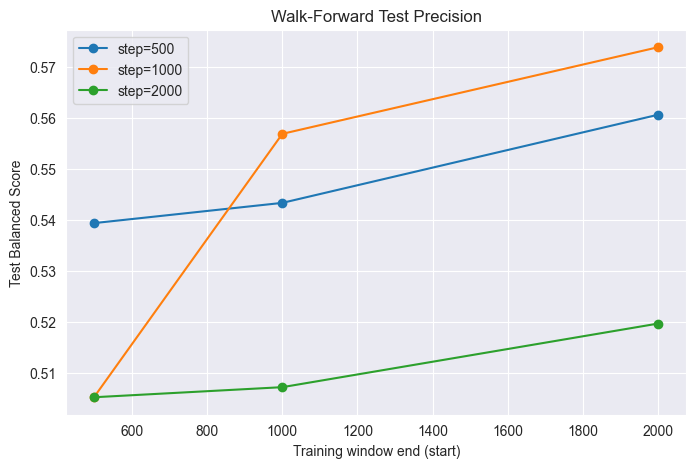

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for step in wf_results['step'].unique():
    subset = wf_results[wf_results['step']==step]
    plt.plot(subset['start'], subset['balanced_score'], marker='o', label=f'step={step}')
plt.xlabel("Training window end (start)")
plt.ylabel("Test Balanced Score")
plt.title("Walk-Forward Test Precision")
plt.legend()
plt.show()


## Best Model

(28987, 20)

=== Final Model Evaluation ===
Precision: 0.6595
Recall: 0.2588
F1-score: 0.3717
Accuracy: 0.5705
Train Precision: 0.7515
Test Precision: 0.6650
Overfitting Ratio: 1.13

=== Feature Importances ===
Close_Ratio_5             72.56
momentum_5                68.04
ibovespa_close            25.76
Trend_2                   18.25
rolling_std_5             17.72
Close_Ratio_55            17.09
rolling_return_5          12.35
Trend_5                   11.76
day_of_week               10.82
Trend_55                  10.31
volume_per_quantity       9.21
Close_Ratio_220           9.06
quantity                  8.25
price_range               8.06
rolling_volume_5          6.96


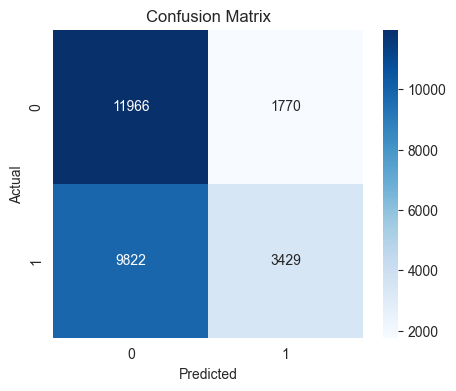

In [28]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv("../data/2019-2023_stock_with_features_dif_tickers.csv")

features = [
    'quantity', 'volume', 'ibovespa_close', 'day_of_week', 'price_range',
    'volume_per_quantity', 'rolling_std_5', 'rolling_return_5', 'momentum_5',
    'rolling_volume_5', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_55',
    'Trend_55', 'Close_Ratio_220'
]

# -----------------------------
# Define the Best Model
# -----------------------------
best_params = {
    'n_estimators': 200,
    'max_depth': 2,
    'learning_rate': 0.05,
    'min_child_weight': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'gamma': 1,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'tree_method': 'hist',
    'random_state': 1
}

model = XGBClassifier(**best_params)

# -----------------------------
# Backtest Function
# -----------------------------
def backtest(df, model, features, start=2000, step=1000, threshold=0.6):
    all_preds = []
    train_precisions, test_precisions = [], []

    for i, idx in enumerate(range(start, df.shape[0], step), 1):
        train = df.iloc[:idx].copy()
        test = df.iloc[idx:idx + step].copy()

        model.fit(train[features], train['target'])
        train_preds = (model.predict_proba(train[features])[:,1] >= threshold).astype(int)
        test_preds = (model.predict_proba(test[features])[:,1] >= threshold).astype(int)

        train_prec = precision_score(train['target'], train_preds)
        test_prec = precision_score(test['target'], test_preds)

        train_precisions.append(train_prec)
        test_precisions.append(test_prec)

        preds = pd.DataFrame({'target': test['target'], 'Predictions': test_preds}, index=test.index)
        all_preds.append(preds)

    avg_train = sum(train_precisions) / len(train_precisions)
    avg_test = sum(test_precisions) / len(test_precisions)

    preds_df = pd.concat(all_preds)
    preds_df.attrs['train_precision'] = avg_train
    preds_df.attrs['test_precision'] = avg_test
    return preds_df

# -----------------------------
# Run Backtest
# -----------------------------
predictions = backtest(df, model, features)

# -----------------------------
# Final Model Evaluation
# -----------------------------
y_true = predictions['target']
y_pred = predictions['Predictions']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
train_prec = predictions.attrs['train_precision']
test_prec = predictions.attrs['test_precision']
f1_Score = f1_score(y_true, y_pred)
overfit_ratio = train_prec / test_prec

print("\n=== Final Model Evaluation ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_Score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Train Precision: {train_prec:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Overfitting Ratio: {overfit_ratio:.2f}")


# -----------------------------
# Feature Importance
# -----------------------------
importances = model.get_booster().get_score(importance_type='gain')
print("\n=== Feature Importances ===")
for feature, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature:<25} {score:.2f}")

# -----------------------------
# Confusion Matrix
# -----------------------------

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()


## Feature Importance

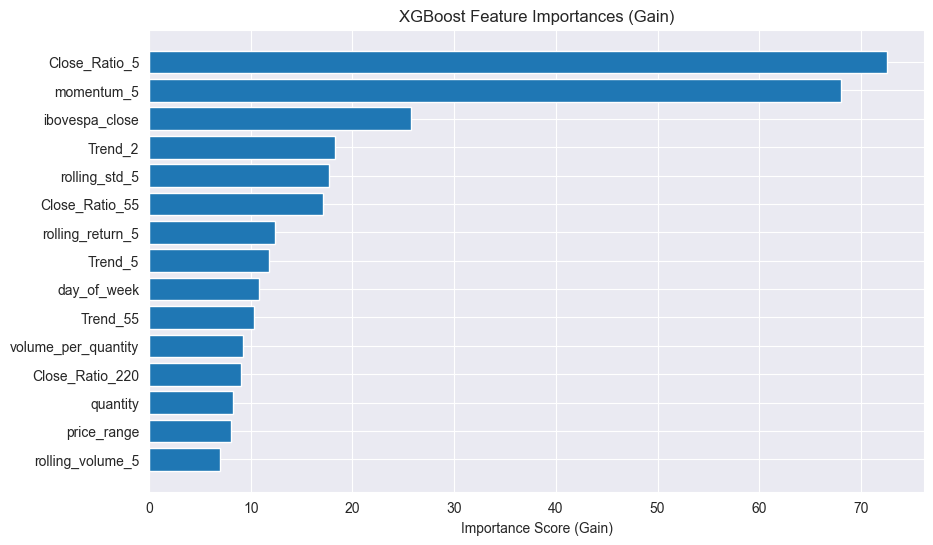

In [17]:
import matplotlib.pyplot as plt

importances_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*importances_sorted)

plt.figure(figsize=(10,6))
plt.barh(features, scores)
plt.gca().invert_yaxis()  # Largest on top
plt.title("XGBoost Feature Importances (Gain)")
plt.xlabel("Importance Score (Gain)")
plt.show()


## Our Interpretation

| Metric               | Value           | Interpretation                                                                                                                          |
| -------------------- | --------------- |-----------------------------------------------------------------------------------------------------------------------------------------|
| Precision            | 0.6595          | ~66% of the predicted buy signals were correct. Decent as avoiding false trades is important.                                           |
| Recall               | 0.2588          | Only ~26% of actual buy signals were captured. Low recall means many opportunities are missed, but this is due to our threshold of 0.6. |
| Accuracy             | 0.5705          | Slightly better than random (~50%), but misleading in imbalanced classes.                                                               |
| Train/Test Precision | 0.7515 / 0.6650 | Some overfitting, but overfitting ratio = 1.13 is low → model generalizes reasonably.                                                   |


### Feature Importances

 - Short-term features dominate: Close_Ratio_5, momentum_5, this makes sense as we are trying to predict if the market will go up or down the next day, so longer term features are not as important for short term market volatility and may be redundant.
 - Market index (ibovespa_close) also contributes meaning that the model partly relies on broader market trends.

### Confusion Matrix

- True Positives are much lower than True Negatives meaning that the model is conservative in predicting buy signals.

- Low recall can be tolerated if avoiding false trades is more critical than missing some opportunities.
- We have a clear class imbalance with 3429 TP's and 11966 TN's.

### Strengths and Weaknesses

Strengths:

- Good precision meaning fewer false positives, important in trading.

- Features used are interpretable meaning we can explain why the model makes decisions.

- Backtesting ensures time-series order is respected which avoids lookahead bias.

Weaknesses:

- Low recall meaning that many opportunities are missed.

- Accuracy metric is not very informative due to class imbalance.

- Model is shallow (max_depth=2) meaning it might not capture complex interactions, although higher depth lead to overfitting.

### Final Thoughts

The model demonstrates that short-term market movements can be partially predicted using technical features and recent market trends. While precision is reasonably high (~66%), the low recall (~26%) indicates that the model captures only a subset of potential buy opportunities.

In practice, this means the model is conservative, favoring accuracy of trades over quantity. This can be suitable for a trading strategy where avoiding false positives (bad trades) is more important than missing some profitable trades.

Feature importance analysis shows that short-term momentum and recent price ratios are most informative, which aligns with the goal of predicting next-day price movements. This insight could help in feature engineering for future models.

Despite some overfitting being present, the backtesting shows the model generalizes reasonably well over unseen periods, giving confidence that its predictions are not purely due to chance.

Future improvements could focus on improving recall without sacrificing too much precision, for example via adjusting thresholds, rebalancing classes, or experimenting with different ensembles or deeper models.

Overall, the model provides a useful baseline for building automated or semi-automated trading strategies, but caution is warranted: low recall means many profitable opportunities are missed, and the model should be integrated with other risk management rules.
